In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

rez=100

## this is where I define the models

In [9]:
#whole AB model
def Ab_model(t,c1,c2,r1,r2,hill,IC50):
    Ab_t = c1*np.exp(-r1*t)+c2*np.exp(-r2*t)
    if c1>0:
        E_t = 1/(1+(Ab_t/IC50)**-hill)
    else:
        E_t=0
    return Ab_t,E_t

# # same death rate for U & P
# (12 free parameters + 5 initial conditions)
# - now productive and unproductive have same natural death rates
def model(X,t,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,c1,c2,r1,r2,hill,IC50,psi):  
    dY = np.zeros(7);
    Ab_t,E_t = Ab_model(t,c1,c2,r1,r2,hill,IC50)    

    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
    
    dY[0] = aS - dS*S - Bt*S*V                              #susceptible cells
    dY[1] = (1-tau)*(1-lam)*Bt*S*V - dI*AU - k*E*AU + xi*LU #active unproductively infected
    dY[2] = tau*(1-lam)*Bt*S*V - dI*AP - k*E*AP + xi*LP     #active productively infected
    dY[3] = (1-tau)*lam*Bt*S*V + thL*LU                     #latent unproductively infected
    dY[4] = tau*lam*Bt*S*V + thL*LP                         #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;                #adaptive immune system
    dY[6] = p*AP - g*V - Bt*S*V - psi*Ab_t*V                #virus (with extra Ab clearance)
    return dY

def run_model(tt,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,c1,c2,r1,r2,hill,IC50,psi,X0):
    sol=spi.odeint(model, X0, tt, 
               (aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g,c1,c2,r1,r2,hill,IC50,psi),
               mxstep=1000)
    return sol


2.8905527289546726


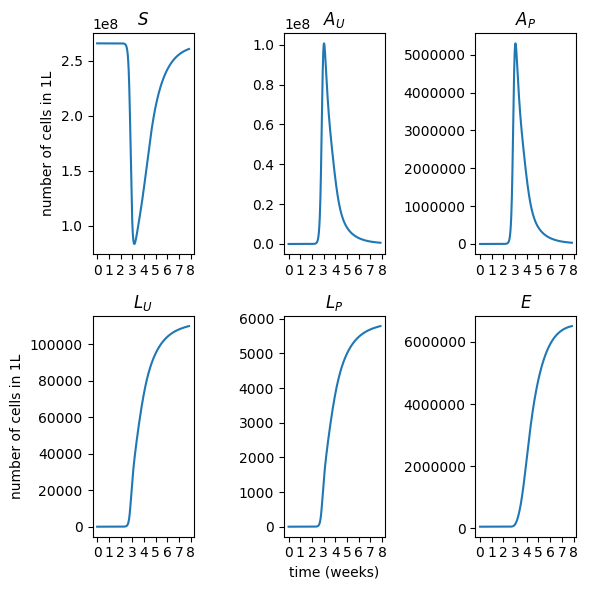

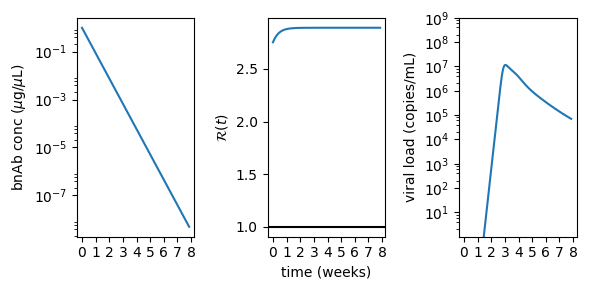

In [11]:

# parameters for viral dynamics model
vol = 1e6       # volume of blood [uL]
aS = 125*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS = 0.47;   #susceptible death rate [1/day] 
Bt  = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 2e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k  = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w  = 1.6;     #immune cell multiplier [1/day]
aE = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE = 0.002;  #immune death rate [1/day]
E50 = 260*vol;   #50 pct max E cell concentration [cells/uL]*[uL]
tau= 0.05   #productively infected probability
p  = 5e4    #leak+burst viral production rate [virions/cell]
g  = 23      #viral clearance [1/day]

#equilibriu solutions
#l=1-(1+xi/thL)*tau #latency factor
#Xeq=np.array([g*dA/Bt0/p/l,tau/thL*(g*dS*dA/Bt0/p/l-aS),aS*l/dA-g*dS/Bt0/p,aS*p*l/g/dA-dS/Bt0])

R0=aS*Bt*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

#PK parameters
#c1,c2,r1,r2 = 225, 35, 0.348, 0.0538 #low 30 or high 10 dose range
c1,c2,r1,r2 = 1, 0, 0.348, 0.0538 #low 30 or high 10 dose range

#PD parameters
IC50=20 # IC50 [ug/uL]
hill=1  # hill coefficient []
psi=3

x0=np.array([aS/dS,0,0,0,0,aE/dE,1e-3]) #initial model conditions

tt=np.linspace(0,55,1e3)

sol=run_model(tt,aS,dS,Bt,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g,c1,c2,r1,r2,hill,IC50,psi,x0)
  
plt.figure(figsize=(6,6),dpi=rez)
titz=['$S$','$A_U$','$A_P$','$L_U$','$L_P$','$E$','$V$']
for i in range(6):
    plt.subplot(231+i)
    plt.plot(tt/7,sol[:,i])
    #plt.axhline(Xeq[i],ls='--',color='k')
    plt.xticks(range(9))
    plt.title(titz[i])
    
    if i==4:
        plt.xlabel('time (weeks)')
    if i==0 or i==3:
        plt.ylabel('number of cells in 1L')
plt.tight_layout()

plt.figure(figsize=(6,3),dpi=rez)
Ab_t,E_t  = Ab_model(tt,c1,c2,r1,r2,hill,IC50)

plt.subplot(131)
plt.semilogy(tt/7,Ab_t)
plt.xticks(range(9))
plt.ylabel('bnAb conc ($\mu$g/$\mu$L)')

plt.subplot(132)
plt.plot(tt/7,(1-E_t)*R0)
plt.axhline(1,color='k')
plt.xticks(range(9))
plt.ylabel(r'$\mathcal{R}(t)$')
plt.xlabel('time (weeks)')

plt.subplot(133)
plt.semilogy(tt/7,sol[:,6]/vol*1e3) #virus/mL
plt.ylim([1,1e9])
plt.yticks(np.logspace(1,9,9))
plt.xticks(range(9))
plt.ylabel('viral load (copies/mL)')
#plt.legend([r'$\beta(Y_t)$',r'$\beta(Y_t)$, $\gamma(Y_t)$',r'$\psi Y_tV$'],fontsize=10,loc=4)

plt.tight_layout()


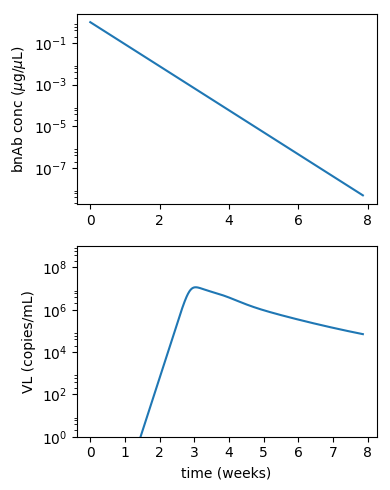

In [12]:
plt.figure(figsize=(4,5),dpi=rez)
plt.subplot(211)
plt.semilogy(tt/7,Ab_t)
plt.ylabel('bnAb conc ($\mu$g/$\mu$L)')

plt.subplot(212)
plt.semilogy(tt/7,sol[:,6]/vol*1e3) #virus/mL
#plt.yticks(np.logspace(1,9,9))
plt.xticks(range(9))
plt.ylabel('VL (copies/mL)')
plt.xlabel('time (weeks)')
#plt.legend([r'$\beta(Y_t)$',r'$\beta(Y_t)$, $\gamma(Y_t)$',r'$\psi Y_tV$'],fontsize=10,loc=4)
plt.ylim([1,1e9])

plt.tight_layout()